In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from unidecode import unidecode
import glob

In [10]:
# Constantes
CSV_PATH = "../data/dados_emprestimos"
PARQUET_PATH = "../data/dados_exemplares.parquet"
CATEGORIAS = {
    range(0, 100): "GENERALIDADES - CIENCIA E CONHECIMENTO",
    range(100, 200): "FILOSOFIA E PSICOLOGIA",
    range(200, 300): "RELIGIAO",
    range(300, 400): "CIENCIAS SOCIAIS",
    range(400, 500): "CLASSE VAGA - PROVISORIAMENTE NAO OCUPADA",
    range(500, 600): "MATEMATICA E CIENCIAS NATURAIS",
    range(600, 700): "CIENCIAS APLICADAS",
    range(700, 800): "BELAS ARTES",
    range(800, 900): "LINGUAGEM - LINGUA - LINGUISTICA",
    range(900, 1000): "GEOGRAFIA - BIOGRAFIA - HISTORIA.",
}

In [11]:
def normalizar_texto(texto):
    """Normaliza strings: remove acentos e converte para maiúsculo."""
    return unidecode(texto).upper()


def carregar_dataframes(caminho):
    """Carrega todos os dataframes de arquivos CSV em um diretório."""
    todos_arquivos = glob.glob(caminho + "/*.csv")
    lista_df = [pd.read_csv(filename, index_col=None, header=0) for filename in todos_arquivos]
    return pd.concat(lista_df, axis=0, ignore_index=True)


def mesclar_dataframes(df1, df2, chave, tipo_mesclagem="inner"):
    """Mescla dois dataframes com base em uma chave comum."""
    return pd.merge(df1, df2, on=chave, how=tipo_mesclagem)


def limpar_dataframe(df):
    """Remove registros com valores nulos e normaliza colunas do tipo string."""
    df = df.dropna()
    df.loc[:, "matricula_ou_siape"] = df["matricula_ou_siape"].astype(int).astype(str)
    df.loc[:, df.select_dtypes(include=["object"]).columns] = df.select_dtypes(include=["object"]).map(normalizar_texto)
    df = df.drop(columns=["registro_sistema"])
    df = df.reset_index(drop=True)
    return df


def mapear_categoria(codigo):
    """Mapeia o código para a categoria correspondente."""
    for chave, valor in CATEGORIAS.items():
        if int(codigo) in chave:
            return valor
    return "CODIGO NAO MAPEADO"


def adicionar_categoria(df):
    """Adiciona a coluna 'categoria' ao dataframe."""
    df["categoria"] = df["localizacao"].apply(mapear_categoria)
    return df

In [12]:
# Carregar os arquivos CSV em um dataframe unificado
df_unificado = carregar_dataframes(CSV_PATH)
# Carregar o arquivo parquet em um dataframe
df_parquet = pd.read_parquet(PARQUET_PATH)
# Mescar os dataframes df_unificado e df_parquet pelo código de barras dos exemplares
df_mesclado = mesclar_dataframes(df_unificado, df_parquet, "codigo_barras")
# Limpar o dataframe mesclado
df_limpo = limpar_dataframe(df_mesclado)
# Adicionar a coluna de categoria ao dataframe
df_final = adicionar_categoria(df_limpo)

/tmp/ipykernel_63893/2913356775.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1636623' '1636623' '1636623' ... '20190054410' '20200090284'
 '20180014073']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, "matricula_ou_siape"] = df["matricula_ou_siape"].astype(int).astype(str)


In [13]:
emprestimos = len(df_final["id_emprestimo"].drop_duplicates())
emprestimos

904866

In [14]:
exemplares = len(df_final)
exemplares

906437

In [15]:
emprestimos_data = pd.DataFrame(df_final["data_emprestimo"].value_counts().reset_index())
emprestimos_data.columns = ["data", "quantidade"]
emprestimos_data["data"] = pd.to_datetime(emprestimos_data["data"])

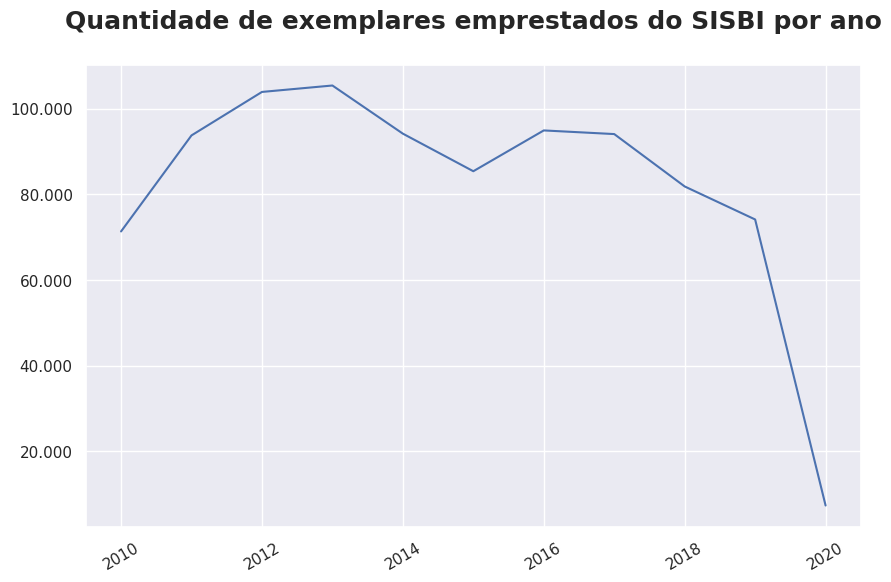

In [18]:
# Configuração global do Seaborn
sns.set_theme(context="notebook", style="darkgrid", palette="deep", font_scale=1, rc={"figure.figsize": (10, 6)})


def plotar_grafico_linhas_total_emprestimos_por_ano(df):
    """Plota um gráfico de linhas com uma linha para cada ano."""
    ax = sns.lineplot(data=df, x="ano", y="quantidade")
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis="x", rotation=30)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ",").replace(",", ".")))
    ax.set_title("Quantidade de exemplares emprestados do SISBI por ano" + "\n", size=18, loc="center", weight="bold")
    plt.savefig("../images/grafico_emprestimos_por_ano.png")


# Preparação dos dados
emprestimos_por_ano = emprestimos_data.groupby(by=emprestimos_data.data.dt.year)["quantidade"].sum()
emprestimos_por_ano = emprestimos_por_ano.reset_index()
emprestimos_por_ano.columns = ["ano", "quantidade"]

# Plotagem do gráfico
plotar_grafico_linhas_total_emprestimos_por_ano(emprestimos_por_ano)

### Análise do gráfico da quantidade de exemplares emprestados por ano

Analisando o gráfico gerado pela função `plotar_grafico_linhas_total_emprestimos_por_ano`, observa-se que ele representa a quantidade de exemplares emprestados do SISBI ao longo dos anos, de 2010 a 2020. 
A linha azul indica a tendência ao longo do tempo, mostrando um aumento constante na quantidade de livros emprestados entre 2010 e 2014. 
Após este período, a quantidade se estabiliza com pequenas flutuações até 2018. 

No entanto, há uma queda significativa após 2018, com o número de empréstimos atingindo o ponto mais baixo em 2020.

Essa queda drástica em 2020 pode ser atribuída a fatores externos, como a pandemia de COVID-19, que resultou no fechamento temporário de bibliotecas ou na redução do acesso físico aos livros. 
Além disso, a tendência de estabilização entre 2014 e 2018 pode indicar uma saturação no número de usuários ou uma mudança nos hábitos de empréstimo, possivelmente devido ao aumento do uso de recursos digitais.

É importante notar que o eixo Y varia de 20.000 a 100.000, o que sugere que mesmo no ponto mais baixo, em 2020, ainda houve uma quantidade significativa de empréstimos, embora muito menor em comparação aos anos anteriores. 
A análise desse gráfico pode ajudar a instituição a entender as mudanças no comportamento de empréstimos ao longo do tempo e a planejar estratégias para aumentar o engajamento e o uso dos recursos da biblioteca.

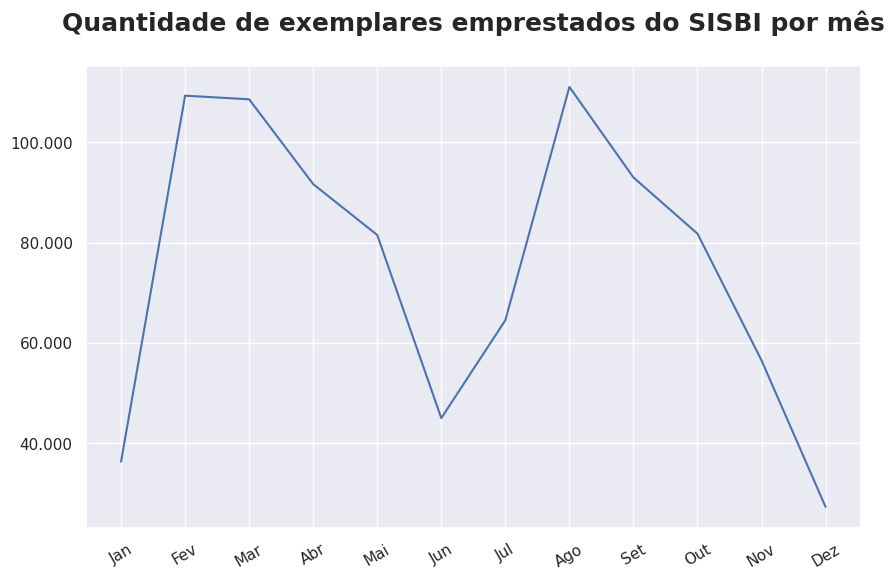

In [ ]:
def plotar_grafico_linhas_total_emprestimos_por_mes(df):
    """Plota um gráfico de linhas com uma linha para cada mês."""
    ax = sns.lineplot(data=df, x="mes", y="quantidade")
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis="x", rotation=30)
    # Formatar o eixo x para mostrar todos os meses
    ax.set_xticks(range(1, 13))  # Definir os ticks do eixo x para os meses (1 a 12)
    ax.set_xticklabels(
        ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
    )  # Nomes dos meses

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ",").replace(",", ".")))
    ax.set_title("Quantidade de exemplares emprestados do SISBI por mês" + "\n", size=18, loc="center", weight="bold")
    plt.savefig("../images/grafico_emprestimos_por_mes.png")

# Preparação dos dados
emprestimos_por_mes = emprestimos_data.groupby(by=emprestimos_data.data.dt.month)["quantidade"].sum()
emprestimos_por_mes = emprestimos_por_mes.reset_index()
emprestimos_por_mes.columns = ["mes", "quantidade"]

# Plotagem do gráfico
plotar_grafico_linhas_total_emprestimos_por_mes(emprestimos_por_mes)

### Análise do gráfico da quantidade de exemplares emprestados por mês

Analisando o gráfico gerado pela função `plotar_grafico_linhas_total_emprestimos_por_mes`, observamos que ele representa a quantidade de exemplares emprestados do SISBI por mês ao longo de um ano.
A linha azul escura no gráfico mostra uma tendência geral decrescente na quantidade de empréstimos de janeiro a dezembro. 
O gráfico começa com um número alto em janeiro, diminui até março, tem um aumento notável em maio, e depois segue uma queda acentuada até dezembro.

A escala vertical do gráfico varia de 40.000 a 100.000 exemplares, indicando que o mês com o menor número de empréstimos ainda teve uma quantidade significativa de 40.000 exemplares emprestados. 
O pico em maio sugere um evento sazonal ou uma demanda específica que levou a um aumento nos empréstimos durante esse mês.

A tendência decrescente pode ser devido a vários fatores, como mudanças sazonais na demanda por empréstimos, alterações no estoque de livros disponíveis, ou até mesmo mudanças nas políticas de empréstimo. 